<p align="center">
<img style="width:60%" src="https://github.com/sersonSerson/Projects/blob/master/Regression/HousePrice/data/HouseForSale.jpg?raw=true">
</p>

[Image source](http://www.clipartbest.com/clipart-yioLdA9eT)

<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">House prices.<br> Part 3. <br> Ridge regression.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/03%20Ridge%20regression.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1.	[Feature engineering.](#Step1)
## 1.1. [Fill missing data.](#Step1.1)
## 1.2. [Generate new features.](#Step1.2)
## 1.3. [Feature encoding.](#Step1.3)
## 1.4. [Modify distributions.](#Step1.4)
## 1.5. [Category clustering.](#Step1.5)
## 2. [Bagging and tuning.](#Step2)
## 3. [Fit and score the model.](#Step3)
## 4. [Make predictions and generate a submission.](#Step4)

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.ensemble import BaggingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold, GridSearchCV, cross_val_predict, \
    train_test_split

In [84]:
pd.options.display.max_colwidth = 120

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Feature engineering.</span>


Define variables

In [85]:
scored_model = Ridge(random_state=0)
dependent_variable = 'SalePrice'
id_column = 'Id'
N_JOBS = 7

# Load data

In [86]:
train_data = pd.read_csv('Data/train.csv', index_col=id_column,
                         float_precision='round_trip')
test_data = pd.read_csv('Data/test.csv', index_col=id_column,
                        float_precision='round_trip')
full_data = pd.concat([train_data, test_data], ignore_index=False)

In [87]:
categorical_features = \
    ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
     'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
     'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
     'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
     'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
     'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
     'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
     'MiscFeature', 'SaleType', 'SaleCondition']
numerical_features = \
    ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
     '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
     'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
     'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
     'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

full_data = full_data[[*numerical_features, *categorical_features,
                       dependent_variable]]

In [88]:
# Sort the columns of DF
full_data.sort_index(axis=1, inplace=True)

In [89]:
# Sort the features list
categorical_features = sorted(categorical_features)
numerical_features = sorted(numerical_features)

In [90]:
# Create train and test datasets
processed_train = full_data.loc[full_data[dependent_variable].notna()]
processed_test = full_data.loc[full_data[dependent_variable].isna()]

# Split train data into X and y
X = processed_train.drop([dependent_variable], axis=1)
y = processed_train[dependent_variable]
X_test = processed_test.drop([dependent_variable], axis=1)

print(f'Shape of X: {X.shape}\n'
      f'Shape of y: {y.shape}')

Shape of X: (1460, 79)
Shape of y: (1460,)


<div id="Step1.1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.1. Fill missing data.</span>


In [91]:
print(f'Missing values before imputing: {X.isna().sum().sum()}')

Missing values before imputing: 6965


In [92]:
X_full = pd.concat([X, X_test])
X_full['LotFrontage'].fillna(X_full['LotFrontage'].mean(), inplace=True)
X_full['Electrical'].fillna('SBrkr', inplace=True)
X_full['Functional'].fillna('Typ', inplace=True)
X_full['KitchenQual'].fillna('TA', inplace=True)
X_full['MSZoning'].fillna('RL', inplace=True)
X_full['SaleType'].fillna('WD', inplace=True)
X_full['Utilities'].fillna('AllPub', inplace=True)
X_full['Exterior1st'].fillna('Wd Sdng', inplace=True)
X_full['Exterior2nd'].fillna('MetalSd', inplace=True)
X_full['PoolQC'].fillna('Gd', inplace=True)

CATEGORICAL_NA = 'No'
categorical_features_to_fill = ['PoolQC', 'Fence', 'MiscFeature',
                                'FireplaceQu', 'Alley', 'MasVnrType']
numerical_features_to_fill = ['GarageYrBlt', 'GarageCars', 'GarageArea',
                              'MasVnrArea']

# Basement
basement_categorical = ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
                        'BsmtCond', 'BsmtExposure']
categorical_features_to_fill += basement_categorical

basement_numerical = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                      'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
X_full[basement_numerical] = X_full[basement_numerical].fillna(0)


# Garage
X_full['GarageYrBlt'].replace(2207, 2007, inplace=True)
garage_categorical = ['GarageType', 'GarageFinish', 'GarageQual',
                      'GarageCond']

# Fill categorical features with 'No'
categorical_features_to_fill += garage_categorical
X_full[categorical_features_to_fill] = \
    X_full[categorical_features_to_fill].fillna(CATEGORICAL_NA)

# Fill numerical features with 0
X_full[numerical_features_to_fill] = \
    X_full[numerical_features_to_fill].fillna(0)


In [93]:
print(f'Missing values after imputing: {X_full.isna().sum().sum()}')

Missing values after imputing: 0


<div id="Step1.2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.2. Generate new features.</span>


## Features derived from age of the building.

In [94]:
X_full['BuildingAge'] = X_full['YrSold'] - X_full['YearBuilt']
X_full['BuildingAge'] = np.where(X_full['BuildingAge'] > 0,
                                 X_full['BuildingAge'], 0)
numerical_features.append('BuildingAge')

X_full['RemodelledAge'] = X_full['YrSold'] - X_full['YearRemodAdd']
X_full['RemodelledAge'] = np.where(X_full['RemodelledAge'] > 0,
                                   X_full['RemodelledAge'], 0)
numerical_features.append('RemodelledAge')
X_full['GarageAge'] = np.where(X_full['GarageYrBlt'] == 0, 0,
                               X_full['YrSold'] - X_full[
                                     'GarageYrBlt'])
X_full['GarageAge'] = np.where(X_full['GarageAge'] < 0, 0,  X_full['GarageAge'])
numerical_features.append('GarageAge')
X_full[['BuildingAge', 'RemodelledAge', 'GarageAge']].head()

,BuildingAge,RemodelledAge,GarageAge
Id,,,
1,5,5,5.0
2,31,31,31.0
3,7,6,7.0
4,91,36,8.0
5,8,8,8.0


In [95]:
X_full['BeforeCrisis'] = np.where(X_full['YrSold'] < 2010, 1, 0)
categorical_features.append('BeforeCrisis')

## Number of Storeys

In [96]:
floors = {20: 1, 30: 1, 40: 1, 45: 1, 50: 1, 60: 2, 70: 2, 75: 2, 80: 2,
          85: 2, 90: 2, 120: 1, 150: 1, 160: 2, 180: 2, 190: 2}
X_full['Floors'] = X_full['MSSubClass'].map(floors)
categorical_features.append('Floors')
X_full[['Floors']].head()

,Floors
Id,
1,2
2,1
3,2
4,2
5,2


## Features from area of the building

In [97]:
X_full['TotalAreaSF'] = X_full['GrLivArea'] \
                          + X_full['TotalBsmtSF']
numerical_features.append('TotalAreaSF')

X_full['BasementFinishedPercent'] = \
    (X_full['TotalBsmtSF'] - X_full['BsmtUnfSF']) / X_full[
        'TotalBsmtSF']
X_full['BasementFinishedPercent'].fillna(0, inplace=True)
numerical_features.append('BasementFinishedPercent')

In [98]:
X_full['TotalAreaSFBinned'] = \
    pd.cut(X_full['TotalAreaSF'], bins=30, right=True).cat.codes
categorical_features.append('TotalAreaSFBinned')
X_full[['TotalAreaSFBinned']].head()

,TotalAreaSFBinned
Id,
1,5
2,5
3,6
4,5
5,7


## Year of sale

In [99]:
X_full['Year'] = X_full['YrSold'].map(
    {2006: 1, 2007: 2, 2008: 3, 2009: 4, 2010: 5})
categorical_features.append('Year')
X_full[['Year']].head()

,Year
Id,
1,3
2,2
3,3
4,1
5,3


## Turn some categorical features into numerical features

In [100]:
condition_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, 'No': 0}
columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
           'KitchenQual', 'FireplaceQu', 'GarageQual', 'PoolQC', 'GarageCond']
for column in columns:
    new_column_name = column + 'Num'
    X_full[new_column_name] = X_full[column].map(condition_dict)
    numerical_features.append(new_column_name)
X_full[[column + 'Num' for column in columns]].head()

,ExterQualNum,ExterCondNum,BsmtQualNum,BsmtCondNum,HeatingQCNum,KitchenQualNum,FireplaceQuNum,GarageQualNum,PoolQCNum,GarageCondNum
Id,,,,,,,,,,
1,4,3,4,3,5,4,0,3,4,3
2,3,3,4,3,5,3,3,3,4,3
3,4,3,4,3,5,4,3,3,4,3
4,3,3,3,4,4,4,4,3,4,3
5,4,3,4,3,5,4,3,3,4,3


In [101]:
condition_dict = {'Gd': 3, 'Av': 2, 'Mn': 1, 'NA': 0, 'No': 0,
                  'No Basement': 0}

X_full['BsmtExposureNum'] = X_full['BsmtExposure'].map(
    condition_dict)
numerical_features.append('BsmtExposureNum')

condition_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2,
                  'Unf': 1, 'NA': 0, 'No': 0}

X_full['BsmtFinType1Num'] = X_full['BsmtFinType1'].map(
    condition_dict)
numerical_features.append('BsmtFinType1Num')

X_full['BsmtFinType2Num'] = X_full['BsmtFinType2'].map(
    condition_dict)
numerical_features.append('BsmtFinType2Num')

condition_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No': 0, 'NA': 0}
X_full['GarageFinishNum'] = X_full['GarageFinish'].map(
    condition_dict)
numerical_features.append('GarageFinishNum')

condition_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'No': 0}
X_full['FenceNum'] = X_full['Fence'].map(condition_dict)
numerical_features.append('FenceNum')

## Composed features

In [102]:
X_full['OverallQualOverallCond'] = X_full['OverallQual'] + X_full[
    'OverallCond']
numerical_features.append('OverallQualOverallCond')

X_full['RoomSize'] = \
    X_full['GrLivArea'] + X_full['TotRmsAbvGrd']
numerical_features.append('RoomSize')

X_full['SumAge'] = (X_full['BuildingAge'] + X_full[
    'RemodelledAge'])
numerical_features.append('SumAge')

X_full['OverallQualTotalAreaSFMultiplied'] = \
    X_full['OverallQual'] * X_full['TotalAreaSF']
numerical_features.append('OverallQualTotalAreaSFMultiplied')

X_full['QualSquared'] = \
    np.square(X_full['OverallQual'].astype(np.int64))
numerical_features.append('QualSquared')
X_full[['OverallQualOverallCond', 'RoomSize', 'SumAge',
        'OverallQualTotalAreaSFMultiplied', 'QualSquared']]

,OverallQualOverallCond,RoomSize,SumAge,OverallQualTotalAreaSFMultiplied,QualSquared
Id,,,,,
1,12,1718,10,17962.0,49
2,14,1268,62,15144.0,36
3,12,1792,13,18942.0,49
4,12,1724,127,17311.0,49
5,13,2207,16,26744.0,64
...,...,...,...,...,...
2915,11,1097,72,6552.0,16
2916,9,1098,72,6552.0,16
2917,12,1231,56,12240.0,25


In [103]:
# Sort the features list
numerical_features = sorted(numerical_features)

## Remove categorical features replaced by numerical ones.

In [104]:
replaced_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                     'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
X_full.drop(replaced_features, axis=1, inplace=True)
for feature in replaced_features:
    categorical_features.remove(feature)
X_full.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,...,BsmtExposureNum,BsmtFinType1Num,BsmtFinType2Num,GarageFinishNum,FenceNum,OverallQualOverallCond,RoomSize,SumAge,OverallQualTotalAreaSFMultiplied,QualSquared
Id,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,No,3,1Fam,706.0,0.0,1.0,0.0,...,0,6,1,2,0,12,1718,10,17962.0,49
2,1262,0,0,No,3,1Fam,978.0,0.0,0.0,1.0,...,3,5,1,2,0,14,1268,62,15144.0,36
3,920,866,0,No,3,1Fam,486.0,0.0,1.0,0.0,...,1,6,1,2,0,12,1792,13,18942.0,49
4,961,756,0,No,3,1Fam,216.0,0.0,1.0,0.0,...,0,5,1,1,0,12,1724,127,17311.0,49
5,1145,1053,0,No,4,1Fam,655.0,0.0,1.0,0.0,...,2,6,1,2,0,13,2207,16,26744.0,64


## Generate statistical features.

In [105]:
def generate_statistic_features(group_features, statistic_features, X,
                                functions=None, function_names=None):
    if functions is None or function_names is None:
        functions = (np.mean,)
        function_names = ['Mean']

    new_numerical_features = []
    for group_feature in group_features:
        for statistic_feature in statistic_features:
            grouped = X.groupby(group_feature, as_index=False).agg(
                {statistic_feature: functions})

            if isinstance(group_feature, list):
                group_feature_names = ''.join([name for name in group_feature])
                statistic_feature_names = [
                    group_feature_names + statistic_feature + name for name
                    in function_names]
                columns = [*group_feature] + statistic_feature_names
            else:
                statistic_feature_names = [
                    group_feature + statistic_feature + name for name
                    in function_names]
                columns = [group_feature] + statistic_feature_names

            new_numerical_features = new_numerical_features + statistic_feature_names
            grouped.columns = columns
            X = X.reset_index().merge(grouped, how='left', on=group_feature)\
                .set_index(id_column)

    return X, new_numerical_features

new_numerical_features = []
group_features = [
    ['OverallQual', 'Neighborhood'],
    'Neighborhood']
statistic_features = ['TotalAreaSF']
X_full, added_features = \
    generate_statistic_features(group_features, statistic_features, X_full)
new_numerical_features += added_features

group_features = ['Neighborhood', 'TotalAreaSFBinned']
statistic_features = ['OverallQual']
X_full, added_features = \
    generate_statistic_features(group_features, statistic_features, X_full)
new_numerical_features += added_features

# Sort the features list
new_numerical_features = sorted(new_numerical_features)
numerical_features += new_numerical_features
X_full[new_numerical_features]

,NeighborhoodOverallQualMean,NeighborhoodTotalAreaSFMean,OverallQualNeighborhoodTotalAreaSFMean,TotalAreaSFBinnedOverallQualMean
Id,,,,
1,6.677903,2654.168539,2804.090164,5.934233
2,7.208333,3252.125000,2529.400000,5.934233
3,6.677903,2654.168539,2804.090164,6.473140
4,6.271845,2759.951456,2814.769231,5.934233
5,7.929577,3914.859155,3883.906977,6.931138
...,...,...,...,...
2915,4.378378,1677.675676,1532.720000,5.133166
2916,4.378378,1677.675676,1532.720000,5.133166
2917,5.543860,2407.105263,2168.071429,5.934233


<div id="Step1.3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.3. Feature encoding.</span>

In [106]:
def generate_column_name(col, function_name, dependent_variable):

    if not isinstance(col, list):
        col = [col]
    name = ''.join([str(elem) for elem in col]) \
           + function_name + dependent_variable

    return name


def generate_dependent_features_new(X, y, columns, dependent_variable,
                                    functions=None, function_names=None,
                                    replace=False, fill_empty_with_mean=False):

    if functions is None or function_names is None:
        functions = (np.mean)
        function_names = ['Mean']

    full_df = pd.concat([X, y], axis=1)
    full_train = full_df.loc[full_df[dependent_variable].notna()]

    # Fill the training set categorical features with function of dependent
    # variable
    filled_train, new_numerical_columns = \
        fill_train_dataset(full_train, columns,
                           dependent_variable=dependent_variable,
                           functions=functions, function_names=function_names,
                           replace=replace, fill_empty_with_mean=fill_empty_with_mean)

    # Fill the values for the test (competition) set
    X_tr = fill_test_dataset(filled_train, full_df, columns,
                             dependent_variable=dependent_variable,
                             functions=functions, function_names=function_names,
                             replace=replace, fill_empty_with_mean=fill_empty_with_mean)

    if replace:
        X_tr.drop(columns, axis=1, inplace=True)
        columns = {colname + function_names[0] + dependent_variable:
                       colname for colname in columns}
        X_tr.rename(columns=columns,
                    inplace=True)
        return X_tr
    else:
        return X_tr, new_numerical_columns


def fill_train_dataset(full_train, columns, dependent_variable='DV',
                       functions=None, function_names=None, replace=False,
                       fill_empty_with_mean=False):
    # Generate 5 splits not to fill the values with the dependent variable of
    # the test set.
    skf = KFold(5, shuffle=True, random_state=0)
    skf.get_n_splits()
    full_train_new = full_train.copy()
    # Algorithm of work:
    # 1. Cycle through each split to avoid using the very example when filling means
    # 2. Cycle through each grouping column (column list)
    # 3. Cycle through each function
    index_name = full_train.index.name
    new_numerical_columns = []
    for tr_ind, val_ind in skf.split(full_train, full_train[dependent_variable]):
        X_tr, X_val = full_train.iloc[tr_ind], full_train.iloc[val_ind]
        for col in columns:
            for function, function_name in zip(functions, function_names):
                name = generate_column_name(col, function_name,
                                            dependent_variable)
                # Generate columns for the new features
                if name not in full_train_new.columns:
                    full_train_new[name] = 0
                    new_numerical_columns.append(name)

                x_tr_means = \
                    X_tr.groupby(col)[dependent_variable].agg(
                        function).rename(name)
                # After merging the index of a DataFrame is reset, so:
                # 1. Create separate indexes column with reset_index()
                # 2. Merge with the means (don't use map() as there can be
                #    multiple grouping columns
                # 3. Set index back to the columns with set_index()

                full_train_new.iloc[
                    val_ind, full_train_new.columns.get_loc(name)] = \
                    X_val.reset_index().merge(x_tr_means, on=col,
                                              how='left').set_index(index_name)[name]

    if fill_empty_with_mean:
        # Fill the values for the rows that have no other rows to take mean from
        prior = full_train_new[dependent_variable].mean()
        full_train_new.fillna(prior, inplace=True)

    return full_train_new, new_numerical_columns


def fill_test_dataset(full_train, full_df, columns, dependent_variable='DV',
                      functions=None, function_names=None, replace=False,
                      fill_empty_with_mean=False):
    prior = full_train[dependent_variable].mean()
    index_name = full_train.index.name
    for col in columns:
        for function, function_name in zip(functions, function_names):
            name = generate_column_name(col, function_name,
                                        dependent_variable)
            full_df.loc[:, name] = full_train[name]
            full_tr_means = full_train.groupby(col)[
                dependent_variable].agg(
                np.mean).rename(name)
            test_rows = full_df[dependent_variable].isna() == True
            full_df.loc[test_rows, name] = \
                full_df.loc[test_rows].drop(name, axis=1).\
                reset_index().merge(full_tr_means, on=col, how='left'). \
                set_index(index_name)[name]

            if fill_empty_with_mean:
                # Fill the values for the rows that have no other rows
                # to take mean from
                full_df.loc[:, name].fillna(prior, inplace=True)

    full_df.drop(dependent_variable, inplace=True, axis=1)

    return full_df

## Mean encoding
1. Create new columns.
2. Fill them with mean of the dependent variable.
In our case - average price of a house with such a feature.

### Before

In [107]:
X_full[categorical_features].head()

,Alley,BldgType,CentralAir,Condition1,Condition2,Electrical,Exterior1st,Exterior2nd,Foundation,Functional,...,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,BeforeCrisis,Floors,TotalAreaSFBinned,Year
Id,,,,,,,,,,,,,,,,,,,,,
1,No,1Fam,Y,Norm,Norm,SBrkr,VinylSd,VinylSd,PConc,Typ,...,CompShg,Gable,Normal,WD,Pave,AllPub,1,2,5,3
2,No,1Fam,Y,Feedr,Norm,SBrkr,MetalSd,MetalSd,CBlock,Typ,...,CompShg,Gable,Normal,WD,Pave,AllPub,1,1,5,2
3,No,1Fam,Y,Norm,Norm,SBrkr,VinylSd,VinylSd,PConc,Typ,...,CompShg,Gable,Normal,WD,Pave,AllPub,1,2,6,3
4,No,1Fam,Y,Norm,Norm,SBrkr,Wd Sdng,Wd Shng,BrkTil,Typ,...,CompShg,Gable,Abnorml,WD,Pave,AllPub,1,2,5,1
5,No,1Fam,Y,Norm,Norm,SBrkr,VinylSd,VinylSd,PConc,Typ,...,CompShg,Gable,Normal,WD,Pave,AllPub,1,2,7,3


In [108]:
y_enc = \
    pd.concat([y, pd.Series([np.nan for i in range(len(X_test))],
              index=X_test.index, name='SalePrice')])
X_full = \
    generate_dependent_features_new(X_full, y_enc, columns=categorical_features,
                                    functions=[np.mean],
                                    dependent_variable='SalePrice',
                                    fill_empty_with_mean=True,
                                    function_names=['Mean'], replace=True)
X, X_test = X_full.iloc[:len(X)], X_full.iloc[len(X):]

### After

In [109]:
X_full[categorical_features].head()

,Alley,BldgType,CentralAir,Condition1,Condition2,Electrical,Exterior1st,Exterior2nd,Foundation,Functional,...,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,BeforeCrisis,Floors,TotalAreaSFBinned,Year
Id,,,,,,,,,,,,,,,,,,,,,
1,181680.251142,184058.134694,184270.899083,183281.113772,179438.278788,185579.391140,211862.917910,212868.290404,225055.532290,181486.738249,...,178767.331882,169931.007642,173722.146114,172061.187623,179381.807560,179210.682948,179036.150632,192210.290061,162905.480176,172413.308642
2,183253.524157,185725.392457,186158.813761,145369.306452,180922.020690,187009.989632,147198.689024,147184.906250,149658.235644,183816.463235,...,179436.582897,170921.710497,174634.731682,172945.844946,181009.158212,180846.010283,181755.289912,170285.143485,162062.795652,187530.407692
3,183253.524157,185725.392457,186158.813761,183885.405113,180922.020690,187009.989632,216476.152913,217430.650873,225829.750000,183816.463235,...,179436.582897,170921.710497,174634.731682,172945.844946,181009.158212,180846.010283,181755.289912,195628.950515,191534.472906,179548.348178
4,181680.251142,184058.134694,184270.899083,183281.113772,179438.278788,185579.391140,148352.662651,164546.875000,132237.840708,181486.738249,...,178767.331882,169931.007642,143447.474359,172061.187623,179381.807560,179210.682948,179036.150632,192210.290061,162905.480176,180051.384615
5,183253.524157,185725.392457,186158.813761,183885.405113,180922.020690,187009.989632,216476.152913,217430.650873,225829.750000,183816.463235,...,179436.582897,170921.710497,174634.731682,172945.844946,181009.158212,180846.010283,181755.289912,195628.950515,225912.972222,179548.348178


<div id="Step1.4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.4. Modify distributions.</span>

In [110]:
# Configure Matplotlib
plt.style.use('seaborn-muted')
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]

In [111]:
features = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage']

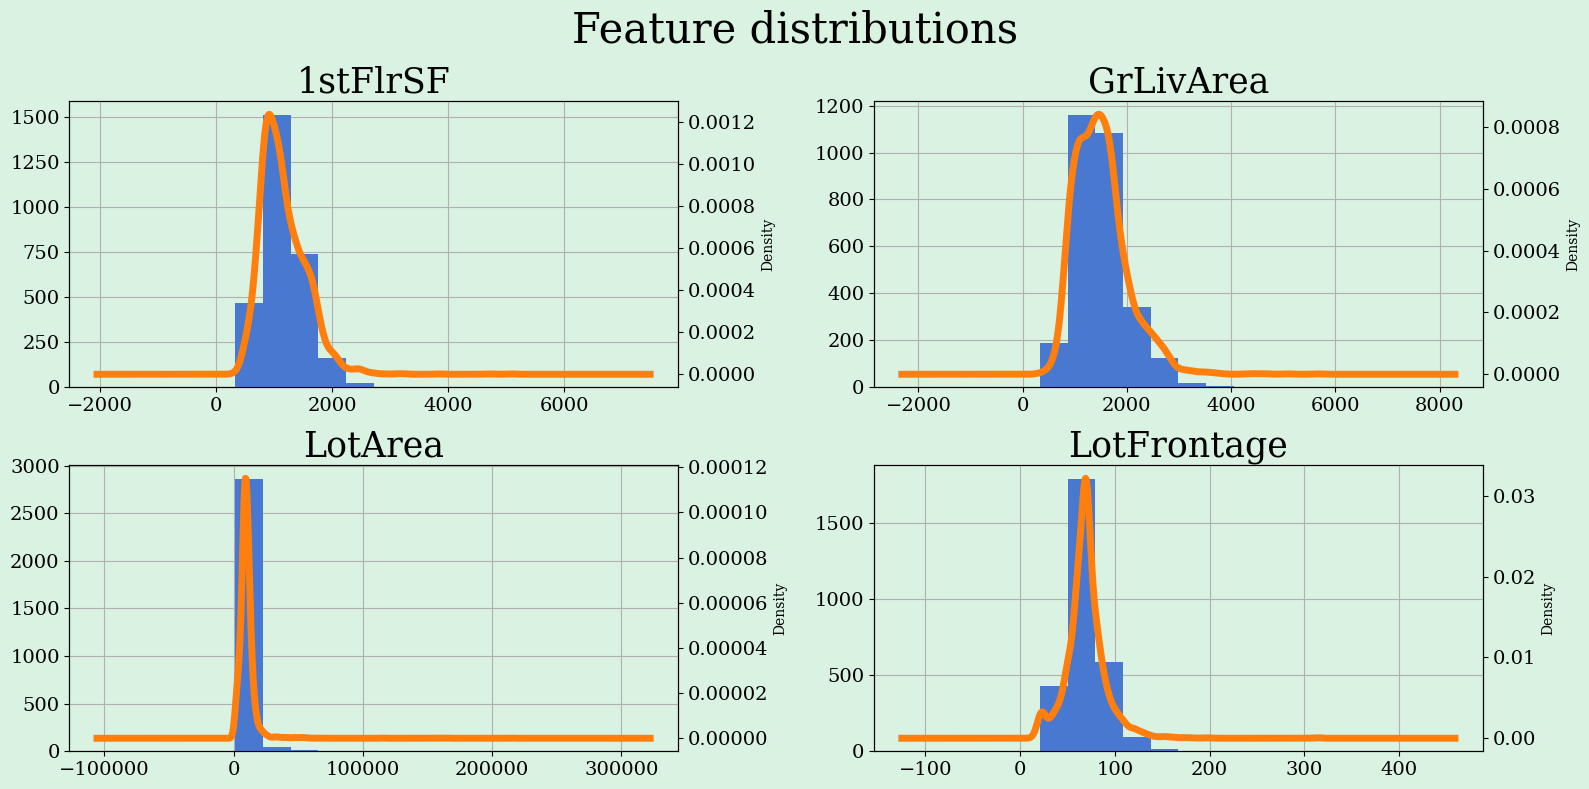

In [112]:
def plot_distributions(df, features):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    X_full = pd.concat([X, X_test])
    X_full[features].hist(zorder=3, ax=axes.ravel()[:len(features)])
    X_full[features].plot(kind='kde', secondary_y=True, subplots=True,
                          ax=axes.ravel()[:len(features)], color=orange,
                          legend=False)
    plt.suptitle('Feature distributions')
    plt.tight_layout()
    plt.show()
plot_distributions(X_full, features)

## Log values to make distributions more Gaussian.

In [113]:
def log_values(df, columns=None, modified=False):
    """
    Creates a log values of the columns passed.

    :param df: DataFrame to convert
    :param columns: list of the columns to convert
    :param modified: use log(1+value) instead of a basic log.
    :return: converted DataFrame
    """
    log_df = df.copy()
    if isinstance(log_df, pd.DataFrame):
        if columns is None:
            columns = log_df.columns
        for column in columns:
            if modified:
                log_df[column] = np.log(log_df[column] + 1)
            else:
                log_df[column] = np.log(log_df[column])
    elif isinstance(log_df, np.ndarray):
        log_df = np.log(log_df + 1)

    return log_df

def exp_values(df, columns=None, modified=False):
    """
    Creates a exp (opposite to log) values of the columns passed.

    :param df: DataFrame to convert
    :param columns: list of the columns to convert
    :param modified: use exp(value) - 1 instead of a basic exp.
    :return: converted DataFrame
    """
    exp_df = df.copy()
    if isinstance(exp_df, pd.DataFrame):
        if columns is None:
            columns = exp_df.columns
        for column in columns:
            exp_df[column] = np.exp(object[column])
            if modified:
                exp_df[column] -= 1
    elif isinstance(exp_df, np.ndarray):
        exp_df = np.exp(exp_df) - 1

    return exp_df

In [114]:
X = log_values(X, modified=True)
X_test = log_values(X_test, modified=True)

ttr = TransformedTargetRegressor(func=log_values, inverse_func=exp_values)
scored_model = \
    TransformedTargetRegressor(func=log_values, inverse_func=exp_values,
                               regressor=scored_model)

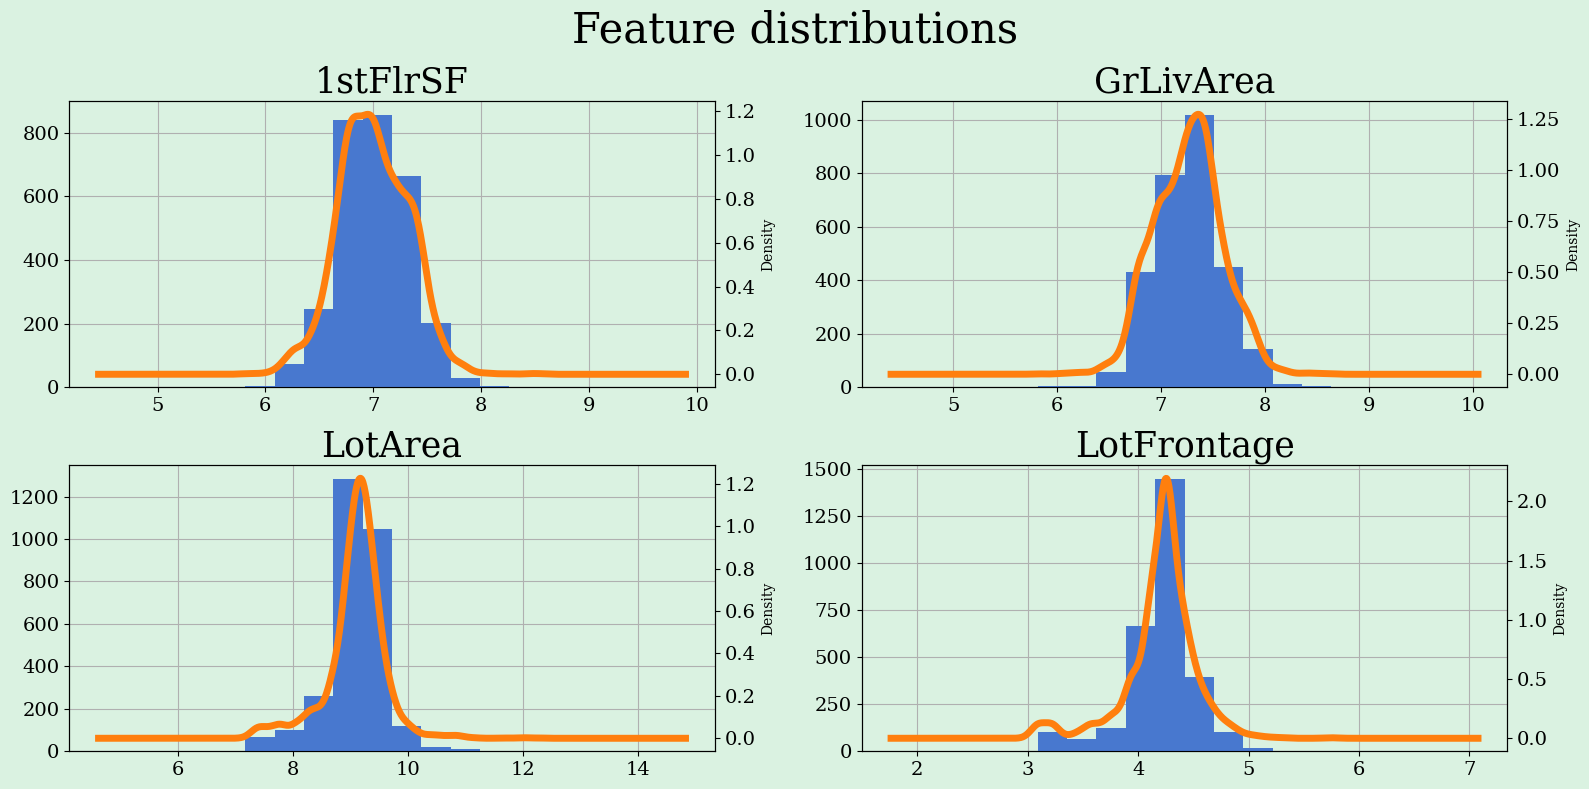

In [115]:
X_full = pd.concat([X, X_test])
plot_distributions(X_full, features)

<div id="Step1.5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1.5. Category clustering.</span>

In [116]:
def k_means_cluster_result(X, X_test=None, clusters=8,
                           new_feature_name='Clusters', features=None):
    X_clust = X.copy()
    X_tr = X.copy()
    if X_test is not None:
        X_test_clust = X_test.copy()
        X_test_tr = X_test.copy()

    if features is not None:
        X_clust = X_clust.loc[:, features]
        if X_test is not None:
            X_test_clust = X_test_clust.loc[:, features]

    kmeans = KMeans(random_state=0)
    kmeans.set_params(n_clusters=clusters)
    kmeans.fit(X_clust)
    X_tr[new_feature_name] = kmeans.predict(X_clust)

    if X_test is not None:
        X_test_tr[new_feature_name] = kmeans.predict(X_test_clust)

    if X_test is not None:
        return X_tr, X_test_tr
    else:
        return X_tr

### Using the K-Means algorithm assign each house to a cluster based on group of features:
1. Neighborhood features.
2. House type features.
3. Terrace features.
4. Sale parameters features.
5. Quality and condition features.
6. Garage features.
7. House size features.

In [117]:

feature_groups = []
neighborhood_clusters = \
    {'Features': ['Neighborhood', 'MSZoning', 'Condition1', 'Condition2'],
     'Name': 'NeighbourhoodCluster', 'Scale': False, 'Clusters': 15}
feature_groups.append(neighborhood_clusters)

house_type_clusters = {
    'Features': ['MSSubClass', 'BldgType', 'HouseStyle'],
    'Name': 'HouseTypeClusters', 'Scale': False, 'Clusters': 2}
feature_groups.append(house_type_clusters)

terrace_clusters = {
    'Features': ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
                 'ScreenPorch'],
    'Name': 'TerraceClusters', 'Scale': False, 'Clusters': 3}
feature_groups.append(terrace_clusters)

sale_parameters_clusters = {
    'Features': ['SaleType', 'SaleCondition'],
    'Name': 'SaleParametersClusters', 'Scale': False, 'Clusters': 20}
feature_groups.append(sale_parameters_clusters)

quality_condition_clusters = {
    'Features': ['OverallQual', 'OverallCond', 'ExterQualNum', 'ExterCondNum',
                 'BsmtQualNum', 'BsmtCondNum', 'KitchenQualNum',
                 'GarageQualNum'],
    'Name': 'QualityConditionClusters', 'Scale': False, 'Clusters': 15}
feature_groups.append(quality_condition_clusters)

garage_clusters = {
    'Features': ['GarageAge', 'GarageArea', 'GarageCars', 'GarageCondNum',
                 'GarageFinishNum', 'GarageQualNum', 'GarageType'],
    'Name': 'GarageClusters', 'Scale': False, 'Clusters': 7}
feature_groups.append(garage_clusters)

size_clusters = {
    'Features': ['1stFlrSF', '2ndFlrSF', 'OverallQualTotalAreaSFMultiplied',
                 'TotalAreaSF', 'TotalAreaSFBinned', 'TotalBsmtSF'],
    'Name': 'SizeClusters', 'Scale': False, 'Clusters': 10}
feature_groups.append(size_clusters)

for feature_group in feature_groups:
    X, X_test = \
        k_means_cluster_result(X, X_test,
                               clusters=feature_group['Clusters'],
                               features=feature_group['Features'],
                               new_feature_name=feature_group['Name'])
    numerical_features.append(feature_group['Name'])
X[[feature_group['Name'] for feature_group in feature_groups]].head()

,NeighbourhoodCluster,HouseTypeClusters,TerraceClusters,SaleParametersClusters,QualityConditionClusters,GarageClusters,SizeClusters
Id,,,,,,,
1,10,0,1,0,10,6,9
2,12,0,0,0,8,5,1
3,1,0,1,0,10,4,0
4,1,0,1,3,12,4,9
5,3,0,0,0,10,4,0


<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Bagging and tuning.</span>

In [118]:
def rmsle(y, y_pred):
    """ A scoring function of Root Mean Squared Log Error

    :param real:
    :param predicted:
    :return:
    """
    sum = 0

    if isinstance(y, pd.Series):
        y = np.array(y)

    for real, pred in zip(y, y_pred):
        # check for negative values
        if real < 0 or pred < 0:
            continue
        p = np.log(real + 1)
        r = np.log(pred + 1)
        sum += np.square(p - r)

    return np.sqrt(sum / len(y_pred))

def rmsle_scorer():
    return make_scorer(rmsle, greater_is_better=False)

def create_bagging_regressor(base_estimator):

    model = BaggingRegressor(base_estimator=base_estimator, n_jobs=N_JOBS,
                             random_state=0)
    return model

bagged_grid = {
    'n_estimators': [150],
    'max_samples': [0.6, 0.8, 0.9, 1.0],
    'max_features': [0.6, 0.8, 0.9, 1.0],
    'base_estimator__regressor__alpha': [0.5, 0.7, 1, 2, 3],
    }

score_func = rmsle_scorer()
kf = KFold(n_splits=5, shuffle=True, random_state=0)
gs_model = GridSearchCV(estimator=create_bagging_regressor(scored_model),
                        param_grid=bagged_grid, cv=kf,
                        verbose=True, n_jobs=N_JOBS, refit=True,
                        scoring=score_func)
gs_model.fit(X, y)
df_results = pd.DataFrame([pd.Series(gs_model.cv_results_['params'], name='Params'),
              pd.Series(gs_model.cv_results_['mean_test_score'], name='Score')]).T
df_results = df_results.sort_values(by=['Score'], ascending=False)
df_results[:7]

Fitting 5 folds for each of 80 candidates, totalling 400 fits


,Params,Score
40,"{'base_estimator__regressor__alpha': 1, 'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 150}",-0.119952
24,"{'base_estimator__regressor__alpha': 0.7, 'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 150}",-0.119961
8,"{'base_estimator__regressor__alpha': 0.5, 'max_features': 0.9, 'max_samples': 0.6, 'n_estimators': 150}",-0.12005
44,"{'base_estimator__regressor__alpha': 1, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 150}",-0.120138
41,"{'base_estimator__regressor__alpha': 1, 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 150}",-0.120144
58,"{'base_estimator__regressor__alpha': 2, 'max_features': 0.9, 'max_samples': 0.9, 'n_estimators': 150}",-0.120147
42,"{'base_estimator__regressor__alpha': 1, 'max_features': 0.9, 'max_samples': 0.9, 'n_estimators': 150}",-0.120152


In [119]:
best_params = df_results.iloc[0]['Params']
scored_model = create_bagging_regressor(base_estimator=scored_model)
scored_model = scored_model.set_params(**best_params)

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 3. Fit and score the model.</span>

In [120]:
def cross_validation_score(model, X, y, score_func=None, fit_params=None):

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    np.random.seed(0)
    if score_func:
        cv_score = cross_val_score(model, X, y, n_jobs=N_JOBS, cv=kf,
                                   scoring=score_func, fit_params=fit_params)
    else:
        cv_score = cross_val_score(model, X, y, n_jobs=N_JOBS, cv=kf,
                                   fit_params=fit_params)
    return np.mean(cv_score)

model = scored_model.fit(X, y)
print('CV score of prediction:',
      cross_validation_score(model, X, y, score_func=score_func))

# Make a prediction
sub_prediction = model.predict(X_test)
sub_prediction = pd.Series(sub_prediction, index=X_test.index)

CV score of prediction: -0.11995248690582035


In [121]:
X_train, X_val, y_train, y_val = \
    train_test_split(X, y, test_size=0.2,  random_state=42)

scored_model.fit(X_train, y_train)
train_prediction = \
    scored_model.predict(X_val)
train_prediction = pd.Series(train_prediction, index=X_val.index)

<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px;background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 4. Make predictions and generate a submission.</span>

In [122]:
def make_submission(preds, filename='Submission'):
    submission_df = pd.DataFrame({'SalePrice': preds},
                                 index=preds.index)
    submission_df.sort_index(inplace=True)
    submission_df.to_csv(f'{filename}.csv', index=True)

make_submission(sub_prediction, 'Predictions/RidgeRegression')
make_submission(train_prediction, 'Predictions/RidgeRegressionVal')

## Save true

In [123]:
make_submission(y_val, 'Predictions/y_val')

In [124]:
print('Ready!')

Ready!


## [Part 1. EDA.](https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/01%20EDA.ipynb)

## [Part 2. ANN.](https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/02%20ANN.ipynb)

## [Part 4. Ensemble.](https://nbviewer.org/github/sersonSerson/Projects/blob/master/Regression/HousePrice/04%20Ensemble.ipynb)
